# Plot zip code areas, shaded based on delta or value

In [10]:
import matplotlib.cm #colormaps
import matplotlib.pyplot as plt #plotting framework
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

from mpl_toolkits.basemap import Basemap #plotting 2d data on maps
import pandas as pd #data structures and analysis tools
import numpy as np #scientific computations
import json #working with json format

## Read and process input data

In [2]:
#import dummy json and process into usable dataframe - move to Chris' project??
with open('/Users/matt.fee/Projects/Mapping Data/PlotRealEstate/dummydata.json') as data_file: #import Json  
    data = json.load(data_file) 
inputDf = pd.DataFrame(data) #convert to dataframe for further processing
inputDf = inputDf.T #transpose so columns = delta,value
inputDf['zip'] = inputDf.index #make zip a column
inputDf.reset_index(drop="True",inplace="True") #reset index to (0,1,2...) <- last couple steps unecessary??
print (inputDf.head(1))

   delta     value    zip
0  0.105  376900.0  80123


## Create Basemap for Denver area 

In [3]:
fig, ax = plt.subplots(figsize=(50,60)) #unpack generated tuple to more easily use fig and axes objects later
m = Basemap(projection='mill',llcrnrlon=-105.115643,llcrnrlat=39.610317,urcrnrlon=-104.823475,urcrnrlat=39.804448, 
            resolution = 'l', epsg = 4269)
m.arcgisimage(service='World_Street_Map', xpixels=10000, verbose=True, zorder=0) #add street map layer
m.readshapefile('/Users/matt.fee/Projects/Mapping Data/PlotRealEstate/tl_2010_08_zcta510/tl_2010_08_zcta510', 
                'areas', drawbounds = True) #add shapefile layer

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-105.115643,39.610317,-104.823475,39.804448&bboxSR=4269&imageSR=4269&size=10000,6644&dpi=96&format=png32&f=image


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(526,
 5,
 [-109.060256, 36.992424, 0.0, 0.0],
 [-102.040878, 41.003443999999995, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x105c27cf8>)

## Join shape files with input data on zip

In [4]:
polyDf = pd.DataFrame({
    'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
    'zip': [area['ZCTA5CE10'] for area in m.areas_info] }) #create dataframe from shapefile
joinedDf = polyDf.join(inputDf.set_index('zip'), on='zip') #join dummyData to shapefile data on zip
joinedDf = joinedDf.dropna(subset = ['shapes', 'zip', 'delta', 'value']) #drop NaNs - necessary??
joinedDf = joinedDf.drop_duplicates(subset = 'zip', keep = 'first') #drop duplicate zip records
joinedDf = joinedDf.reset_index(drop = True) #reset index
print(joinedDf.head(1))

                          shapes    zip  delta     value
0  Poly((-105.019, 39.7459) ...)  80204  0.128  317400.0


## Create patches and map them to dataframe

In [5]:
featureToMap = "value" # feature to seed color patch values
cmap = plt.get_cmap('Reds') #plot color map with passed value   
pc = PatchCollection(joinedDf.shapes, alpha = .6, linestyle='solid',zorder=2)
norm = Normalize() 
pc.set_facecolor(cmap(norm(joinedDf[featureToMap].fillna(0).values)))
ax.add_collection(pc)

In [6]:
#create colorbar index
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(joinedDf[featureToMap])
cbar = plt.colorbar(mapper,shrink=0.42)
cbar.ax.tick_params(labelsize=30,labeltop="off")

In [8]:
#add zip labels
for index, row in joinedDf.iterrows():
    vertices = ((joinedDf['shapes'].iloc[index].get_xy()))
    sumX = 0
    sumY = 0
    count = 0
    for x in vertices:
        sumX += (x[0])
        sumY += (x[1])
        count += 1
    centroid = (sumX/count,sumY/count)
    lat = (centroid[0])
    long = (centroid[1])
    plt.text(lat, long,(row['zip']),fontsize=36, alpha = .8)

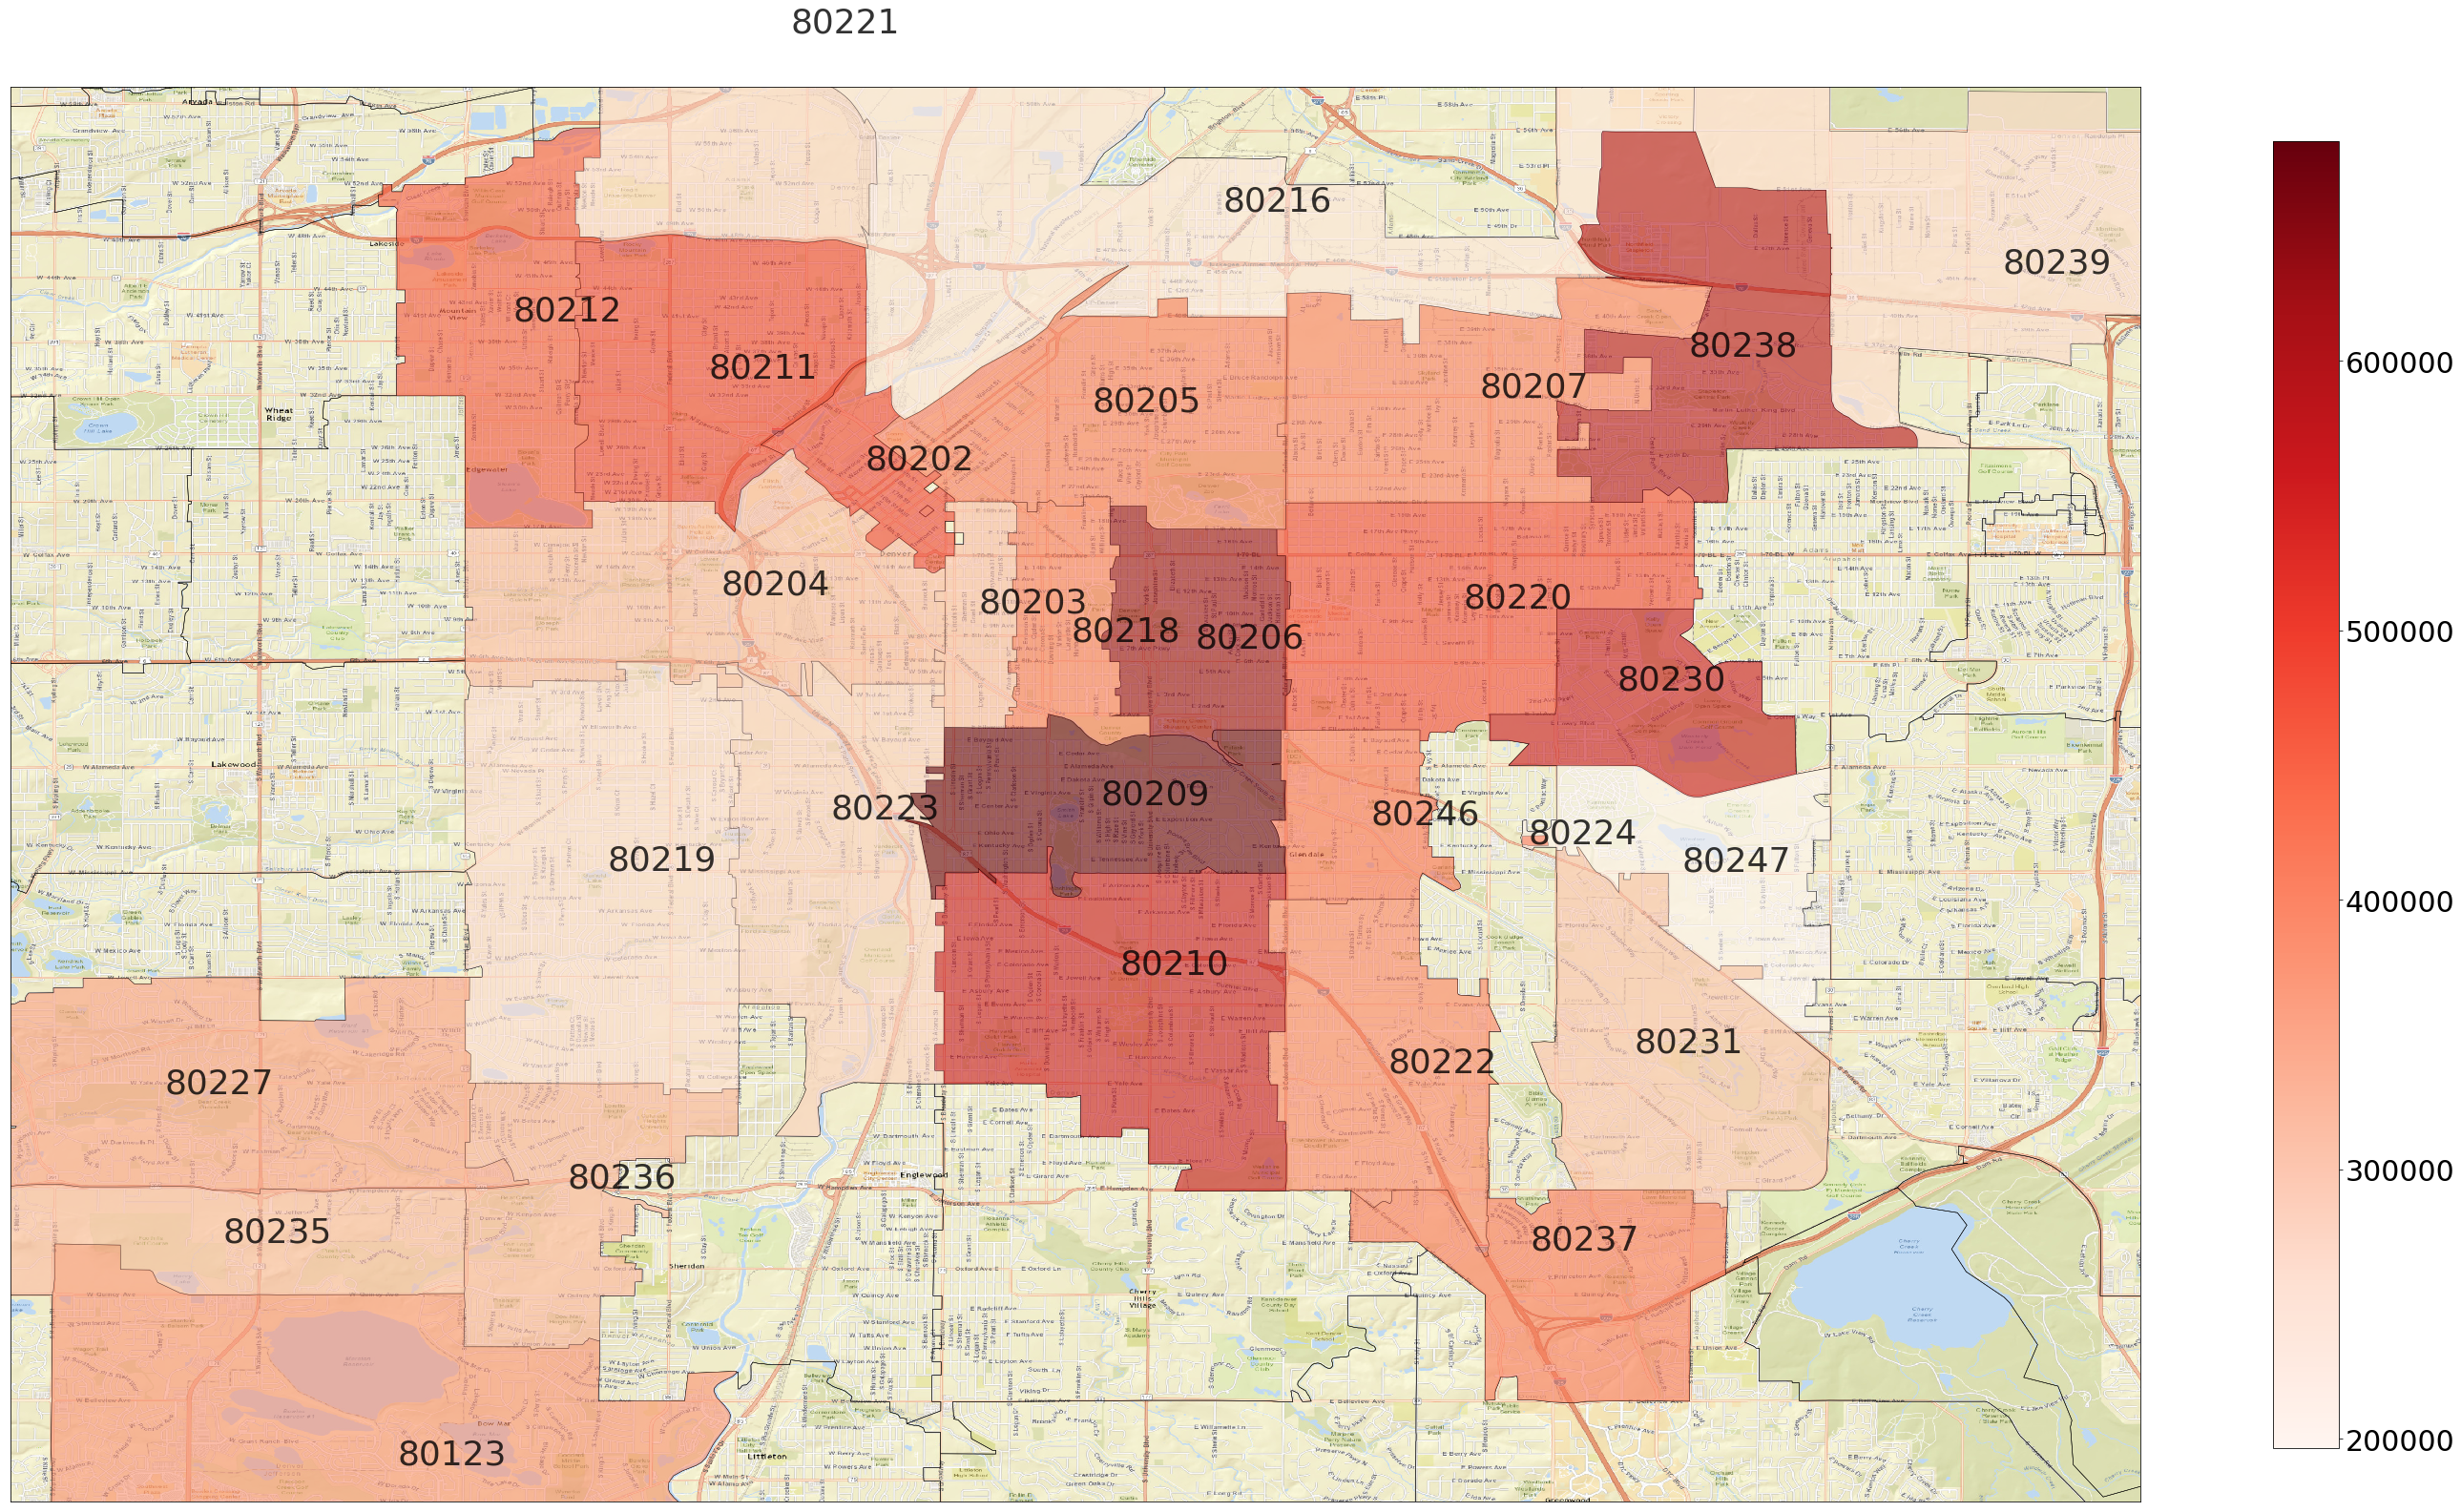

In [9]:
fig.savefig('plots.png')
plt.show()

### To Do:

### 1. Update to accomodate more input data
### 2. Better center map labels? use inCircle from SymPy?
    http://docs.sympy.org/latest/modules/geometry/polygons.html?highlight=geometry#sympy.geometry.polygon.RegularPolygon.incircle
### 3. Label top of the colormap with value above largest in the set
### 4. Format colorbar tick labels as currency
### 5. Dig into polygon issue for zip 80224